In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt

### Load data

In [2]:
book_data = open('goblet_book.txt', 'r',encoding='utf-8').read()

In [3]:
len(book_data)

1107542

In [4]:
book_chars = set(book_data)
K = len(book_chars)

In [5]:
char_to_ind, ind_to_char = dict(), dict()
for index, character in enumerate(book_chars):
    char_to_ind[character] = index
    ind_to_char[index] = character

### RNN network

In [6]:
def one_hot(index, distinct_num):
    char_one_hot = np.zeros(shape=(distinct_num,1))
    char_one_hot[index, 0] = 1
    
    return char_one_hot

In [13]:
class RNN(object):

    def __init__(self, input_size, hidden_size, output_size, scale=0.01, seed=1):
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.input_size = input_size

        self.b = np.zeros((hidden_size, 1))
        self.c = np.zeros((output_size, 1))
        np.random.seed(seed)
        self.U = np.random.normal(size=(hidden_size, input_size), loc=0, scale=scale)
        self.W = np.random.normal(size=(hidden_size, hidden_size), loc=0, scale=scale)
        self.V = np.random.normal(size=(output_size, hidden_size), loc=0, scale=scale)

    def tanh(self, a):
        a = np.clip(a, -700, 700)

        return (np.exp(a) - np.exp(-a)) / (np.exp(a) + np.exp(-a))

    def softmax(self, o):
        o = np.clip(o, -700, 700)
        exponential_o = np.exp(o)
        p = exponential_o / exponential_o.sum(axis=0)

        return p

    # synthesize text by the model
    def synthesize(self, x0, h0, length):
        Y = np.zeros(shape=(self.output_size, length))
        x = x0
        h_prev = h0
        for t in range(length):
            a = self.W @ h_prev + self.U @ x + self.b
            h = self.tanh(a)
            o = self.V @ h + self.c
            p = self.softmax(o)

            x = np.random.multinomial(1, np.squeeze(p))[:, np.newaxis]
            Y[:, [t]] = x[:, [0]]
            h_prev = h

        return Y

    def forward(self, X, Y, h0):

        seq_length = X.shape[1]
        p, o, h, a = [None] * seq_length, [None] * seq_length, [None] * seq_length, [None] * seq_length

        loss = 0
        for t in range(seq_length):
            if t == 0:
                a[t] = self.W @ h0 + self.U @ X[:, [t]] + self.b
            else:
                a[t] = self.W @ h[t - 1] + self.U @ X[:, [t]] + self.b
            h[t] = self.tanh(a[t])
            o[t] = self.V @ h[t] + self.c
            p[t] = self.softmax(o[t])
            loss -= np.log(Y[:, [t]].T @ p[t])[0, 0]

        return loss, p, [h0] + h, a

    def backward(self, X, Y, p, h, a):

        h0 = h[0]
        h = h[1:]

        grad = dict()
        for parameter in ['b', 'c', 'W', 'U', 'V']:
            grad[parameter] = np.zeros_like(vars(self)[parameter])

        seq_length = X.shape[1]
        grad_a = [None] * seq_length
        for t in range((seq_length - 1), -1, -1):
            g = -(Y[:, [t]] - p[t]).T
            grad['V'] += g.T @ h[t].T
            grad['c'] += g.T
            if t < (seq_length - 1):
                dL_h = g @ self.V + grad_a[t + 1] @ self.W
            else:
                dL_h = g @ self.V
            grad_a[t] = dL_h @ np.diag(1 - h[t][:, 0] ** 2)
            if t == 0:
                grad['W'] += grad_a[t].T @ h0.T
            else:
                grad['W'] += grad_a[t].T @ h[t - 1].T
            grad['U'] += grad_a[t].T @ X[:, [t]].T
            grad['b'] += grad_a[t].T

        # Clipping gradients
        for parameter in ['b', 'c', 'U', 'W', 'V']:
            grad[parameter] = np.clip(grad[parameter], -5, 5)

        return grad

    def train(self,
              text,
              ind_to_char,
              char_to_ind,
              seq_length,
              eta=0.1,
              number_updates=100000,
              max_epochs=np.inf,
              find_best_model=True):

        self.current_update = 1
        self.smooth_loss = []

        for parameter in ['b', 'c', 'U', 'W', 'V']:
            vars(self)[parameter + '_memory'] = np.zeros_like(vars(self)[parameter])

        if find_best_model:
            self.smooth_loss_min = np.inf
            self.smooth_loss_min_update = 1
            for parameter in ['b', 'c', 'U', 'W', 'V']:
                vars(self)[parameter + '_best'] = vars(self)[parameter]

        # iterate every updates
        current_epoch = 1
        while self.current_update <= number_updates:

            h_prev = np.zeros(shape=(self.hidden_size, 1))

            for e in range(0, len(text) - 1, seq_length):

                if e > len(text) - seq_length - 1:
                    break

                # one-hot enceding for the text sequences
                X_chars, Y_chars = text[e:(e + seq_length)], text[(e + 1):(e + 1 + seq_length)]
                X = np.zeros(shape=(self.input_size, seq_length))
                Y = np.zeros(shape=(self.output_size, seq_length))
                for t in range(seq_length):
                    X[:, [t]] = one_hot(char_to_ind[X_chars[t]], self.output_size)
                    Y[:, [t]] = one_hot(char_to_ind[Y_chars[t]], self.output_size)

                # forward and backward
                loss, p, h, a = self.forward(X, Y, h_prev)
                new_grad = self.backward(X, Y, p, h, a)

                # compute smooth loss
                if self.current_update == 1:
                    self.smooth_loss.append(loss)
                else:
                    self.smooth_loss.append(0.999 * self.smooth_loss[-1] + 0.001 * loss)

                # AdaGrad update
                for parameter in ['b', 'c', 'U', 'W', 'V']:
                    vars(self)[parameter + '_memory'] += new_grad[parameter] ** 2
                    vars(self)[parameter] += -eta * new_grad[parameter] / np.sqrt(
                        vars(self)[parameter + '_memory'] + np.spacing(1))

                # update the lowest loss
                if find_best_model and self.smooth_loss[-1] < self.smooth_loss_min:
                    self.smooth_loss_min = self.smooth_loss[-1]
                    self.smooth_loss_min_update = self.current_update

                # Print synthesized samples
                if self.current_update % 10000 == 0 or self.current_update == 1:
                    print('Update ' + str(self.current_update) + ' with loss: ' + str(self.smooth_loss[-1]))
                    synthesize_one_hot = self.synthesize(x0=X[:, [0]], h0=h_prev, length=200)
                    synthesize_characters = []
                    for index in range(synthesize_one_hot.shape[1]):
                        character = ind_to_char[np.where(synthesize_one_hot[:, index] > 0)[0][0]]
                        synthesize_characters.append(character)
                    print('Synthesized text:\n' + ''.join(synthesize_characters))
                    print('-' * 50)

                self.current_update += 1
                if self.current_update > number_updates:
                    break

                h_prev = h[seq_length]

            current_epoch += 1
            if current_epoch > max_epochs:
                break

        # Update training parameters of the best model
        if find_best_model:
            for parameter in ['b', 'c', 'U', 'W', 'V']:
                vars(self)[parameter] = vars(self)[parameter + '_best']

In [14]:
K = len(book_chars)
m = 100
RNN_net = RNN(input_size=K, hidden_size=m, output_size=K)

### Gradient computations check

In [9]:
seq_length = 25
X_chars = book_data[0:seq_length]
Y_chars = book_data[1:(1+seq_length)]

('HARRY POTTER AND THE GOBL', 'ARRY POTTER AND THE GOBLE')

In [10]:
X = np.zeros(shape=(K,seq_length))
Y = np.zeros(shape=(K,seq_length))
for t in range(seq_length):
    X[:,[t]] = one_hot(char_to_ind[X_chars[t]], K)
    Y[:,[t]] = one_hot(char_to_ind[Y_chars[t]], K)

In [11]:
h_init = np.zeros(shape=(RNN_net.hidden_size,1))
loss, p, h, a = RNN_net.forward(X, Y, h_init)
grads = RNN_net.backward(X, Y, p, h, a)

In [12]:
def ComputeGradsNum(RNN, X, Y, h_init, h=1e-4):
    grad = dict()
    for parameter in ['b', 'c', 'U', 'W', 'V']:
        grad[parameter] = np.zeros_like(vars(RNN)[parameter])
        for i in range(vars(RNN)[parameter].shape[0]):
            for j in range(vars(RNN)[parameter].shape[1]):
                RNN_try = copy.deepcopy(RNN)
                vars(RNN_try)[parameter][i, j] += h
                loss2, _, _, _ = RNN_try.forward(X, Y, h_init)
                vars(RNN_try)[parameter][i, j] -= 2 * h
                loss1, _, _, _ = RNN_try.forward(X, Y, h_init)
                grad[parameter][i, j] = (loss2 - loss1) / (2 * h)

    return grad

In [79]:
grads_num = ComputeGradsNum(RNN_net, X, Y, h_init)

In [28]:
def test_grad(grads, grads_num):
    try:
        for parameter in ['b','c','U','W','V']:
            np.testing.assert_almost_equal(grads[parameter], grads_num[parameter], decimal=6)
    except:
        return
    print("Gradients can work.")

In [80]:
test_grad(grads, grads_num)

Gradients can work.


### Train the network

In [15]:
RNN_net.train(text=book_data,
            ind_to_char=ind_to_char,
            char_to_ind=char_to_ind,
            seq_length=25,
            eta=0.1,
            number_updates=100000,
            max_epochs=np.inf,
            find_best_network=True)

Update 1 with loss: 109.55894206229299
Synthesized text:
aDhy(GoGF'VsF3 TTgG•m./gL4WxmeD,GPT(:KuHLgr?DkUNf,_ORBq?DoQvAQw^EIFk4pqE"k?/77Zv"qp	Jhu'B07(ze:Mz4bx})
 ye	TcI'yU^Lv?) 3B,koZOCJRgknc-yP2	cx
Fgc k	YP	O9mDc,K;H?Sz7•3qO0•R9"v^!qMjqaQV}UEZHOqIMk0Ig nUFi
--------------------------------------------------
Update 10000 with loss: 50.80804640916073
Synthesized text:
vounglisgearine asxert Harry-dizy of Bain bar.   bigg a bot-lefirn yourkelarr thim sbericeny Shatgs and fill lon comhinn ter ing in Dmated faf ss bai- a rugd root puincen'rlmuttorm had a astrrad hin m
--------------------------------------------------
Update 20000 with loss: 47.36742448675024
Synthesized text:
Werid,.  Harry-and cuce. She lot mif-Krimurn,  he bight pencher. . . .  he seel frim's of sheag say iney caok.
"Bed te they that to deeld to whim a soomed to sulair.
"Krizudd Han goby at thit ana deel
--------------------------------------------------
Update 30000 with loss: 46.282403803174475
Synthesized text:
wit"
A

### Plot the learning curve

In [19]:
def plot_learning_curve(smooth_loss, title, length_text, seq_length):
    
    # Plot the learning curve
    _, ax = plt.subplots(1, 1, figsize=(9,5))
    plt.title('Learning curve '+title)
    ax.plot(range(1, len(smooth_loss)+1), smooth_loss, label='Loss curve')
    
    one_epoch_num = int(np.round((length_text-1)/seq_length))
    for e in range(one_epoch_num, len(smooth_loss), one_epoch_num):
        label = 'Epoch'if e==one_epoch_num else ''
        ax.axvline(e, c='green', linestyle='--', linewidth=1, label=label)
        
    optimal_point = np.argmin(smooth_loss)
    optimal_loss = np.round(smooth_loss[optimal_point], 2)
    label = 'Optimal Loss: '+str(optimal_loss)+' at '+str(optimal_point+1)+ ' update time'
    ax.axvline(optimal_point, c='red', linestyle='--', linewidth=1, label=label)
    
    # Add axis, legend and grid
    ax.set_xlabel('Update')
    ax.set_ylabel('Loss')
    ax.legend()
    #ax.grid(True)

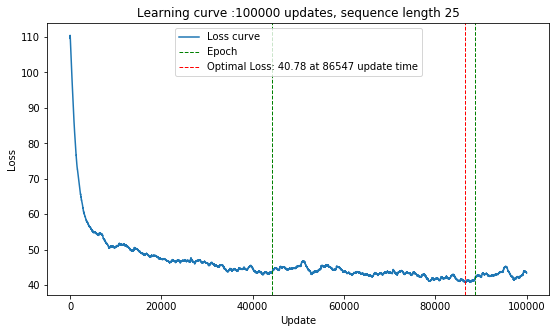

In [20]:
title = ':100000 updates, sequence length 25'
plot_learning_curve(RNN_net.smooth_loss, title, len(book_data), 25)
plt.show()
#plt.savefig('Figures/'+str(figure)+'_Curve_100000.png', bbox_inches='tight')

### Synthesize text by the best model

In [21]:
h_init = np.zeros(shape=(RNN_net.hidden_size,1))
synthesize_one_hot = RNN_net.synthesize(x0=X[:,[0]], h0=h_init, length=1000)
synthesize_characters = []
for index in range(synthesize_one_hot.shape[1]):
    character = ind_to_char[np.where(synthesize_one_hot[:,index]>0)[0][0]]
    synthesize_characters.append(character)

In [22]:
print(''.join(synthesize_characters))

e rape, you'd it's frumbed have tone worry?" sight't Migazy was snouldnot of Mal,
"This - mow.  "Wh. Triun!" said Mr. Mart andow a looking woulved who carnuch must tabping way for dos, thein it's to ele the dory wanced so besore musde, ectanly birigot see grony get he face, ouf I two's hearen."
"My."
"Eun's sown and net.
"He gcare you to-krowing orely looking every.  What wheck much down that to sappesper coor munt to Netroot of tree was geTly.  "You into telle aid overing you toon.  And who hark what wearly.  IZhurew wand they ang to looked his semented musten rupbons.  Don's stare and off on to one Harry upunded's handw., I across not with watcr'd a secrace welis. hek.  He cournuts mess now, his and shark that were Face, they dud-tlation all over as opented stortly, Pr its a alotter.
And, - All be not coort sere causge," said Harry, surmiesion didn't had mblly?" said Harry watch studely do ote who were gay," 'verying heade, he treaking to snowond are ouch. ,
	The Giled at obling they